<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/SRAM_Macros_to_OASIS_Using_GDSTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install libraries (GDSTK, Matplotlib, NumPy, Pylint)
%pip -q install --upgrade pip wheel packaging
%pip -q install "gdstk>=0.9.61" "matplotlib>=3.9" "numpy>=1.26" "pylint>=3.2"

import os
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import gdstk

# Consistent 600-dpi figures for previews
mpl.rcParams["figure.dpi"] = 1200
mpl.rcParams["savefig.dpi"] = 1200

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.9 MB/s eta 0:00:00


In [2]:
# @title Write generator module to disk (cells registered in Library; robust previews; KLayout .lyp)
from pathlib import Path

GEN_PATH = Path("/content/sram_oasis_generator.py")

GEN_PATH.write_text(r'''
"""SRAM macro demo generator: OASIS + 600-dpi previews + KLayout .lyp
- Registers every cell in the GDSTK Library via lib.new_cell(...)
- Exports OASIS (SEMI P39) and an SVG preview
- Renders 600-dpi PNG previews (all-layers + per-layer)
- Emits a minimal KLayout .lyp so layers show with colors on load

DEMO-ONLY GEOMETRY (no PDK, no DRC/LVS). For illustrative SRAM tiling & hierarchy.
"""

from __future__ import annotations

import argparse
import json
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import gdstk

# ------------------------- Library units/precision -------------------------
LIB_UNIT = 1e-6   # user unit = 1 µm
LIB_PREC = 1e-9   # vertex precision in meters

# ------------------------------- Defaults ----------------------------------
BYTES_IS_BINARY = True       # True: KiB (×1024); False: kB (×1000)
TOTAL_BYTES_PER_MACRO = 20   # "20 KiB" if BYTES_IS_BINARY else "20 kB"
MACRO_A_WORD_BITS = 32
MACRO_B_WORD_BITS = 64
BANKS_A = 1
BANKS_B = 1

# Demo bitcell pitch (µm)
BITCELL_PITCH_X = 0.50
BITCELL_PITCH_Y = 0.80

# "full" = flatten copy & draw true polys; "sparse" = bounding boxes of refs
PREVIEW_MODE = "full"

# ------------------------------ Layer map ----------------------------------
@dataclass(frozen=True)
class LayerSpec:
    layer: int
    dtype: int
    name: str
    color: str

LAYER_MAP: Dict[str, LayerSpec] = {
    "NWELL": LayerSpec(64, 0, "NWELL", "#99d8ff"),
    "DIFF":  LayerSpec(65, 0, "DIFF",  "#6ab04c"),
    "POLY":  LayerSpec(66, 0, "POLY",  "#e67e22"),
    "V1":    LayerSpec(67, 0, "V1",    "#8e44ad"),
    "M1":    LayerSpec(68, 0, "M1",    "#3498db"),
    "M2":    LayerSpec(69, 0, "M2",    "#2ecc71"),
    "TXT":   LayerSpec(90, 0, "TEXT",  "#000000"),
}

# ------------------------------ Utilities ----------------------------------
def _bytes_to_bits(n_bytes: int, binary: bool = True) -> int:
    scale = 1024 if binary else 1000
    return n_bytes * scale * 8

def words_for(total_bytes: int, word_bits: int, binary: bool) -> int:
    total_bits = _bytes_to_bits(total_bytes, binary=binary)
    if total_bits % word_bits != 0:
        raise ValueError("Total bits not divisible by word width.")
    return total_bits // word_bits

def near_square_factors(n: int) -> Tuple[int, int]:
    """Find (rows, cols) near sqrt(n); if prime, return (n, 1)."""
    root = int(math.floor(math.sqrt(n)))
    for r in range(root, 0, -1):
        if n % r == 0:
            return r, n // r
    return n, 1

# ------------------------- ShortCircuit/AIG stub ---------------------------
def load_aig_json(path: Optional[Path]) -> Optional[dict]:
    """Optionally load an AIG/ShortCircuit JSON to steer config (stub)."""
    if path is None:
        return None
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"AIG JSON not found: {p}")
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)

# ------------------------------ Geometry -----------------------------------
def demo_bitcell_cell(lib: gdstk.Library, name: str="BITCELL") -> gdstk.Cell:
    """Create a small demo bitcell icon (agnostic layers)."""
    cell = lib.new_cell(name)  # REGISTER in library
    w, h = BITCELL_PITCH_X, BITCELL_PITCH_Y

    nw = gdstk.rectangle((0, 0), (w, h),
                         layer=LAYER_MAP["NWELL"].layer, datatype=LAYER_MAP["NWELL"].dtype)
    diff = gdstk.rectangle((0.10*w, 0.10*h), (0.90*w, 0.40*h),
                           layer=LAYER_MAP["DIFF"].layer,  datatype=LAYER_MAP["DIFF"].dtype)
    poly1 = gdstk.rectangle((0.30*w, 0.00*h), (0.34*w, 1.00*h),
                            layer=LAYER_MAP["POLY"].layer,  datatype=LAYER_MAP["POLY"].dtype)
    poly2 = gdstk.rectangle((0.66*w, 0.00*h), (0.70*w, 1.00*h),
                            layer=LAYER_MAP["POLY"].layer,  datatype=LAYER_MAP["POLY"].dtype)
    m1 = gdstk.rectangle((0.00*w, 0.60*h), (1.00*w, 0.70*h),
                         layer=LAYER_MAP["M1"].layer,    datatype=LAYER_MAP["M1"].dtype)
    v1a = gdstk.rectangle((0.10*w, 0.62*h), (0.14*w, 0.66*h),
                          layer=LAYER_MAP["V1"].layer,    datatype=LAYER_MAP["V1"].dtype)
    v1b = gdstk.rectangle((0.86*w, 0.62*h), (0.90*w, 0.66*h),
                          layer=LAYER_MAP["V1"].layer,    datatype=LAYER_MAP["V1"].dtype)
    m2 = gdstk.rectangle((0.48*w, 0.00*h), (0.52*w, 1.00*h),
                         layer=LAYER_MAP["M2"].layer,    datatype=LAYER_MAP["M2"].dtype)

    cell.add(nw, diff, poly1, poly2, m1, v1a, v1b, m2)
    return cell

def sram_array_cell(lib: gdstk.Library, array_name: str, rows: int, cols: int,
                    bitcell: gdstk.Cell) -> gdstk.Cell:
    """Create an SRAM array by repeating the bitcell via Reference repetition."""
    arr = lib.new_cell(array_name)  # REGISTER in library
    ref = gdstk.Reference(bitcell, columns=cols, rows=rows,
                          spacing=(BITCELL_PITCH_X, BITCELL_PITCH_Y))
    arr.add(ref)
    return arr

def periphery_box(w_um: float, h_um: float, layer_key: str="M1") -> gdstk.Polygon:
    spec = LAYER_MAP[layer_key]
    return gdstk.rectangle((0, 0), (w_um, h_um), layer=spec.layer, datatype=spec.dtype)

def assemble_macro(lib: gdstk.Library, name: str,
                   words: int, word_bits: int, banks: int,
                   bitcell: gdstk.Cell) -> gdstk.Cell:
    """Build a macro = [array + simple periphery + text]."""
    rows, cols = near_square_factors(words)
    macro = lib.new_cell(name)  # REGISTER in library

    array = sram_array_cell(lib, f"{name}_ARRAY", rows, cols, bitcell)
    macro.add(gdstk.Reference(array, origin=(0, 0)))

    # Simple periphery placeholders
    W = cols * BITCELL_PITCH_X
    H = rows * BITCELL_PITCH_Y
    left  = periphery_box(0.25*W, H, "M1")
    right = left.copy().translate(W + 0.05*W, 0)
    top   = periphery_box(W + 0.30*W, 0.20*H, "M2").translate(-0.15*W, H + 0.02*H)
    bot   = periphery_box(W + 0.30*W, 0.20*H, "M2").translate(-0.15*W, -0.22*H)
    macro.add(left, right, top, bot)

    txt = gdstk.text(f"{name}  ({words} words × {word_bits} b)",
                     size=0.18*H, position=(-0.15*W, 1.30*H),
                     layer=LAYER_MAP["TXT"].layer, datatype=LAYER_MAP["TXT"].dtype)
    macro.add(*txt)
    return macro

def place_two_macros(lib: gdstk.Library, macro_a: gdstk.Cell, macro_b: gdstk.Cell) -> gdstk.Cell:
    """Place two macros side-by-side with spacing in TOP cell."""
    top = lib.new_cell("TOP_SRAMS")  # REGISTER in library

    def bbox(cell: gdstk.Cell) -> Tuple[float, float]:
        bb = cell.bounding_box()
        if bb is None:
            return 0.0, 0.0
        (xmin, ymin), (xmax, ymax) = bb
        return float(xmax - xmin), float(ymax - ymin)

    wA, _ = bbox(macro_a)
    wB, _ = bbox(macro_b)
    gap = 0.25 * max(wA, wB)

    top.add(gdstk.Reference(macro_a, origin=(0, 0)))
    top.add(gdstk.Reference(macro_b, origin=(wA + gap, 0)))
    return top

# ------------------------------- Export ------------------------------------
def write_oasis(lib: gdstk.Library, out_path: Path) -> None:
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    lib.write_oas(str(out_path))

def write_klayout_lyp(out_path: Path) -> None:
    """Emit a minimal KLayout .lyp file mapping layer/datatype to colors."""
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    lines = ['<?xml version="1.0" encoding="UTF-8"?>',
             '<layer-properties>']
    for spec in LAYER_MAP.values():
        lines += [
            '  <properties>',
            f'    <name>{spec.name}</name>',
            f'    <source>{spec.layer}/{spec.dtype}@1</source>',
            f'    <frame-color>{spec.color}</frame-color>',
            f'    <fill-color>{spec.color}</fill-color>',
            '    <visible>true</visible>',
            '    <transparent>false</transparent>',
            '    <width>1</width>',
            '    <dither-pattern>I1</dither-pattern>',
            '  </properties>'
        ]
    lines.append('</layer-properties>')
    out_path.write_text("\n".join(lines), encoding="utf-8")

# ------------------------------- Preview -----------------------------------
def _flatten_copy(cell: gdstk.Cell, apply_reps: bool = True) -> gdstk.Cell:
    tmp = cell.copy(name=f"{cell.name}_PREVIEW", deep_copy=True)
    tmp.flatten(apply_repetitions=apply_reps)
    return tmp

def _group_polys_by_spec(cell: gdstk.Cell) -> Dict[Tuple[int, int], List[np.ndarray]]:
    spec_map: Dict[Tuple[int, int], List[np.ndarray]] = {}
    for poly in cell.polygons:
        key = (poly.layer, poly.datatype)
        spec_map.setdefault(key, []).append(np.asarray(poly.points, dtype=float))
    return spec_map

def preview_cell_layers(cell: gdstk.Cell, out_dir: Path, mode: str, title: str) -> None:
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    if mode.lower() == "full":
        draw_cell = _flatten_copy(cell, apply_reps=True)
        spec_to_polys = _group_polys_by_spec(draw_cell)
    else:
        # sparse: draw bboxes for immediate references
        spec_to_polys = {}
        for ref in cell.references:
            bb = ref.cell.bounding_box()
            if bb is None:
                continue
            (xmin, ymin), (xmax, ymax) = bb
            rect = np.array([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
            key = (LAYER_MAP["M1"].layer, LAYER_MAP["M1"].dtype)
            spec_to_polys.setdefault(key, []).append(rect)

    xs, ys = [], []
    for polys in spec_to_polys.values():
        for p in polys:
            xs.extend(p[:, 0]); ys.extend(p[:, 1])
    if not xs or not ys:
        print("No polygons found for preview.")
        return
    xmin, xmax = min(xs), max(xs)
    ymin, ymax = min(ys), max(ys)

    def _setup_ax(ax):
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(xmin - 0.05*(xmax-xmin), xmax + 0.05*(xmax-xmin))
        ax.set_ylim(ymin - 0.05*(ymax-ymin), ymax + 0.05*(ymax-ymin))
        ax.set_xlabel("µm"); ax.set_ylabel("µm")

    color_map = {(v.layer, v.dtype): v.color for v in LAYER_MAP.values()}

    # All-layers composite
    fig, ax = plt.subplots(figsize=(10, 8))
    _setup_ax(ax)
    for spec, polys in spec_to_polys.items():
        color = color_map.get(spec, "#000000")
        for p in polys:
            ax.fill(p[:, 0], p[:, 1], alpha=0.7, facecolor=color, edgecolor="black", linewidth=0.08)
    ax.set_title(f"{title} — All Layers ({mode.lower()})")
    fig.savefig(out_dir / "preview_all_layers.png", bbox_inches="tight")
    plt.close(fig)

    # Per-layer
    for spec, polys in spec_to_polys.items():
        color = color_map.get(spec, "#000000")
        fig, ax = plt.subplots(figsize=(10, 8))
        _setup_ax(ax)
        for p in polys:
            ax.fill(p[:, 0], p[:, 1], alpha=0.9, facecolor=color, edgecolor="black", linewidth=0.12)
        lay, dt = spec
        ax.set_title(f"{title} — Layer {lay}:{dt}")
        fig.savefig(out_dir / f"preview_layer_{lay}_{dt}.png", bbox_inches="tight")
        plt.close(fig)

# ------------------------------ Top-level API ------------------------------
def build_and_export(aig_json_path: Optional[Path],
                     out_root: Path,
                     bytes_is_binary: bool = BYTES_IS_BINARY,
                     macro_a_bits: int = MACRO_A_WORD_BITS,
                     macro_b_bits: int = MACRO_B_WORD_BITS,
                     banks_a: int = BANKS_A,
                     banks_b: int = BANKS_B,
                     preview_mode: str = PREVIEW_MODE) -> Path:
    """Build 2 macros, export OASIS, write previews & .lyp, return OASIS path."""
    _ = load_aig_json(aig_json_path)

    lib = gdstk.Library(name="SRAM_DEMO", unit=LIB_UNIT, precision=LIB_PREC)

    bitcell = demo_bitcell_cell(lib)

    words_a = words_for(TOTAL_BYTES_PER_MACRO, macro_a_bits, bytes_is_binary)
    macro_a = assemble_macro(lib, "SRAM_A_20KiB", words_a, macro_a_bits, banks_a, bitcell)

    words_b = words_for(TOTAL_BYTES_PER_MACRO, macro_b_bits, bytes_is_binary)
    macro_b = assemble_macro(lib, "SRAM_B_20KiB", words_b, macro_b_bits, banks_b, bitcell)

    top = place_two_macros(lib, macro_a, macro_b)

    out_root = Path(out_root)
    out_oas = out_root / "sram_macros.oas"
    write_oasis(lib, out_oas)

    # Previews and SVG
    previews_dir = out_root / "previews"
    preview_cell_layers(top, previews_dir, mode=preview_mode, title="SRAM Macros (Demo)")
    (out_root / "svg").mkdir(parents=True, exist_ok=True)
    top.write_svg(out_root / "svg" / "top_sram.svg", background="white")

    # KLayout layer props
    write_klayout_lyp(out_root / "sram_layers.lyp")
    return out_oas

# ------------------------------- CLI entry ---------------------------------
def parse_args(argv: Optional[Iterable[str]] = None) -> argparse.Namespace:
    p = argparse.ArgumentParser(description="SRAM OASIS generator (demo)")
    p.add_argument("--out_root", type=str, default="/content/out", help="Output root directory")
    p.add_argument("--aig_json", type=str, default=None, help="Optional AIG JSON path")
    p.add_argument("--binary_bytes", action="store_true", help="Use KiB (×1024)")
    p.add_argument("--decimal_bytes", action="store_true", help="Use kB (×1000)")
    p.add_argument("--macro_a_bits", type=int, default=MACRO_A_WORD_BITS)
    p.add_argument("--macro_b_bits", type=int, default=MACRO_B_WORD_BITS)
    p.add_argument("--banks_a", type=int, default=BANKS_A)
    p.add_argument("--banks_b", type=int, default=BANKS_B)
    p.add_argument("--preview_mode", type=str, default=PREVIEW_MODE, choices=["full", "sparse"])
    # Tolerate stray argv (e.g., Jupyter's -f kernel.json)
    args, _unknown = p.parse_known_args(argv)
    return args

def main(argv: Optional[Iterable[str]] = None) -> None:
    args = parse_args(argv)
    bytes_is_binary = True if args.binary_bytes else (False if args.decimal_bytes else BYTES_IS_BINARY)
    out = build_and_export(
        Path(args.aig_json) if args.aig_json else None,
        Path(args.out_root),
        bytes_is_binary=bytes_is_binary,
        macro_a_bits=args.macro_a_bits,
        macro_b_bits=args.macro_b_bits,
        banks_a=args.banks_a,
        banks_b=args.banks_b,
        preview_mode=args.preview_mode,
    )
    print(f"OASIS written to: {out}")
    print(f"Previews in: {Path(args.out_root) / 'previews'}")
    print(f"SVG in: {Path(args.out_root) / 'svg'}")
    print(f"KLayout LYP: {Path(args.out_root) / 'sram_layers.lyp'}")

if __name__ == "__main__":
    main()
''')

print(f"Wrote {GEN_PATH}")


Wrote /content/sram_oasis_generator.py


In [3]:
# @title Build: OASIS + 1200-dpi previews + .lyp (API call)
import importlib.util, sys
from pathlib import Path

spec = importlib.util.spec_from_file_location("sram_oasis_generator", str(GEN_PATH))
mod = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = mod
spec.loader.exec_module(mod)

# Dense preview (flattened repetitions)
oas_path = mod.build_and_export(
    aig_json_path=None,
    out_root=Path("/content/out"),
    bytes_is_binary=True,   # 20 KiB (×1024)
    macro_a_bits=32,
    macro_b_bits=64,
    banks_a=1, banks_b=1,
    preview_mode="full",
)
print("OASIS:", oas_path)
print("Previews dir:", (Path("/content/out") / "previews").resolve())
print("KLayout LYP:", (Path("/content/out") / "sram_layers.lyp").resolve())
print("SVG:", (Path("/content/out") / "svg" / "top_sram.svg").resolve())


OASIS: /content/out/sram_macros.oas
Previews dir: /content/out/previews
KLayout LYP: /content/out/sram_layers.lyp
SVG: /content/out/svg/top_sram.svg


In [4]:
# @title Validate: read OASIS and list cells/layers
import gdstk
from pathlib import Path

oas = Path("/content/out/sram_macros.oas")
assert oas.exists(), f"Missing: {oas}"
lib2 = gdstk.read_oas(str(oas))
print("Top-level cells:", [c.name for c in lib2.top_level()])
print("All (layer, datatype) in library:", sorted(lib2.layers_and_datatypes()))
for c in lib2.top_level():
    print(f"{c.name}: polygons={len(c.polygons)} references={len(c.references)}")


Top-level cells: ['TOP_SRAMS']
All (layer, datatype) in library: [(64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (90, 0)]
TOP_SRAMS: polygons=0 references=2


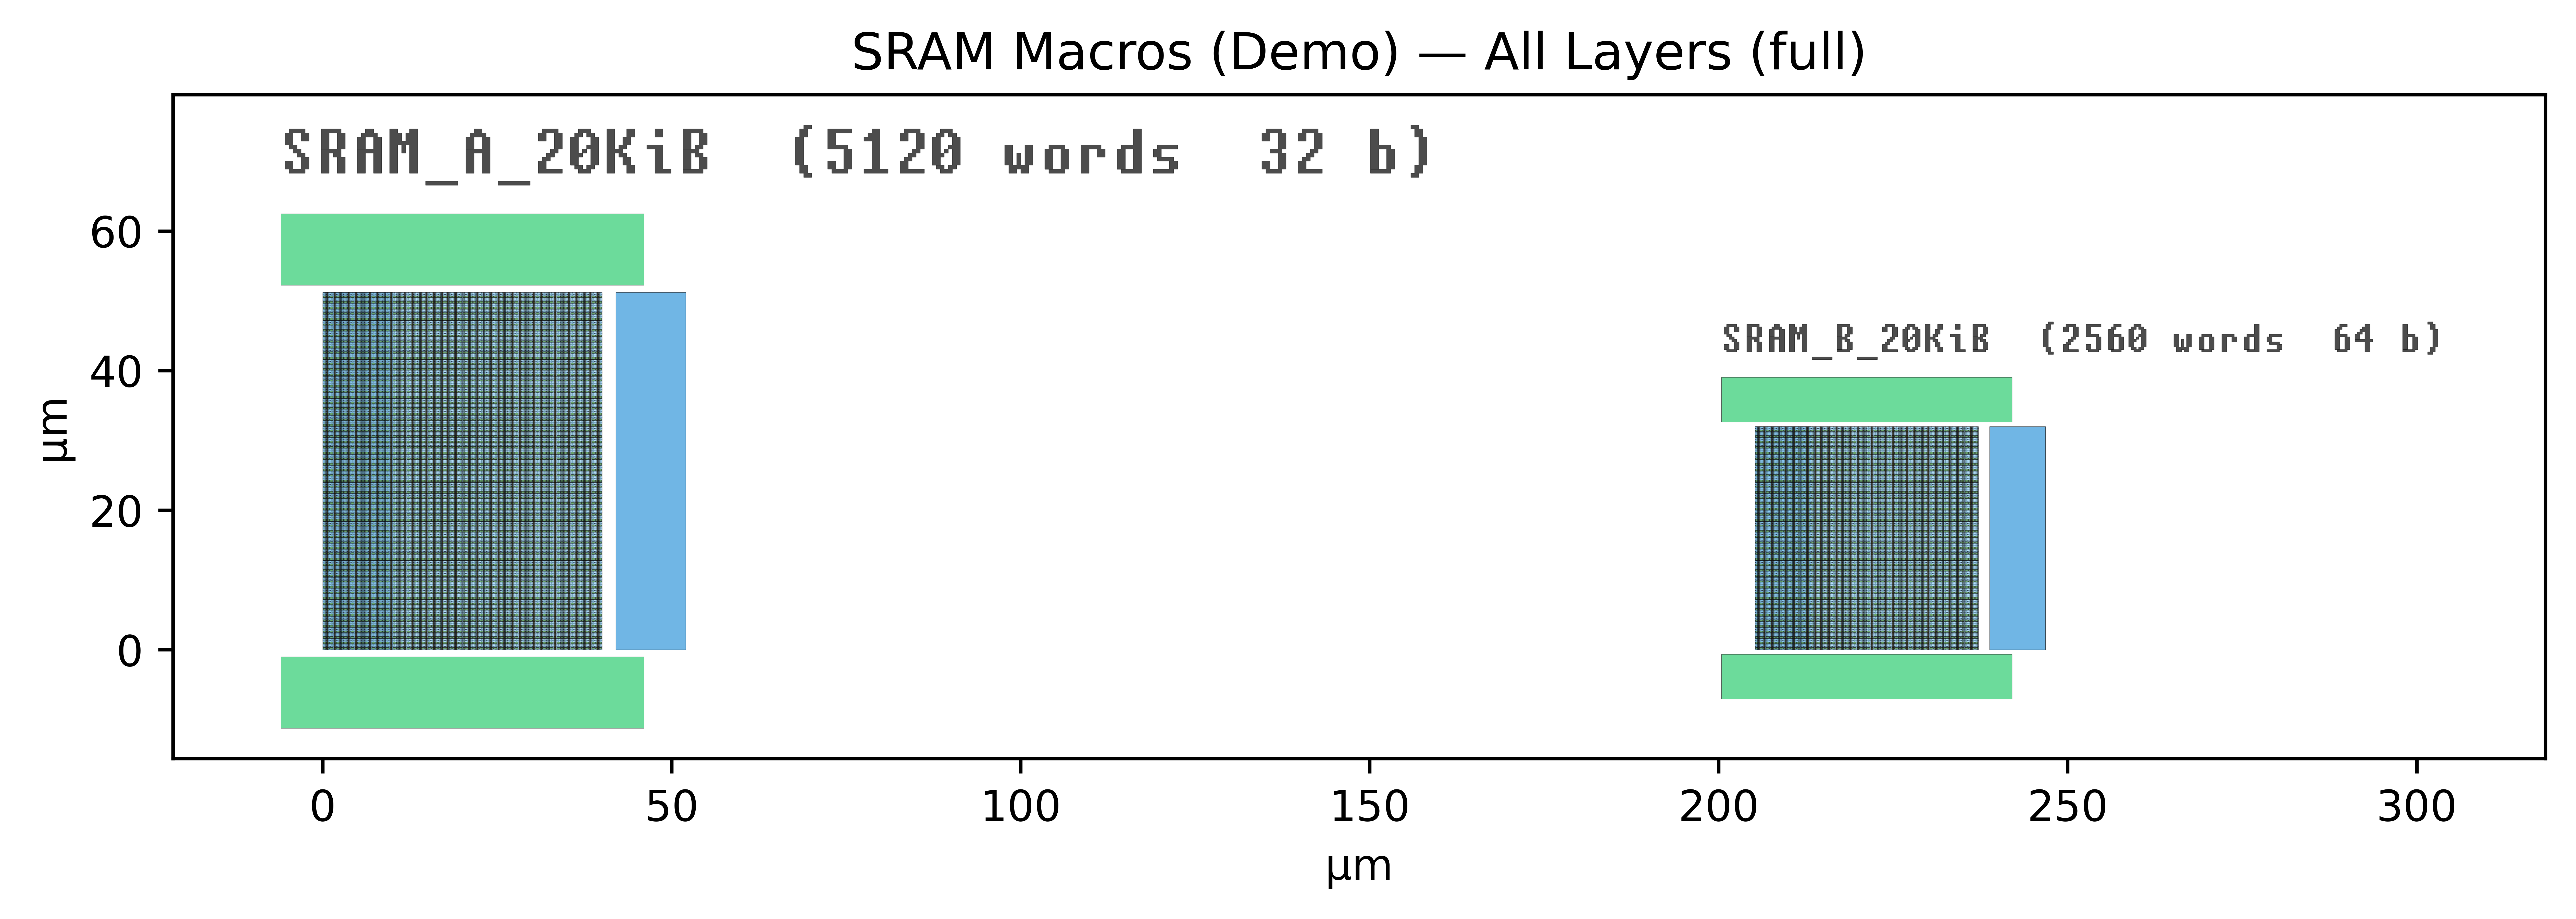

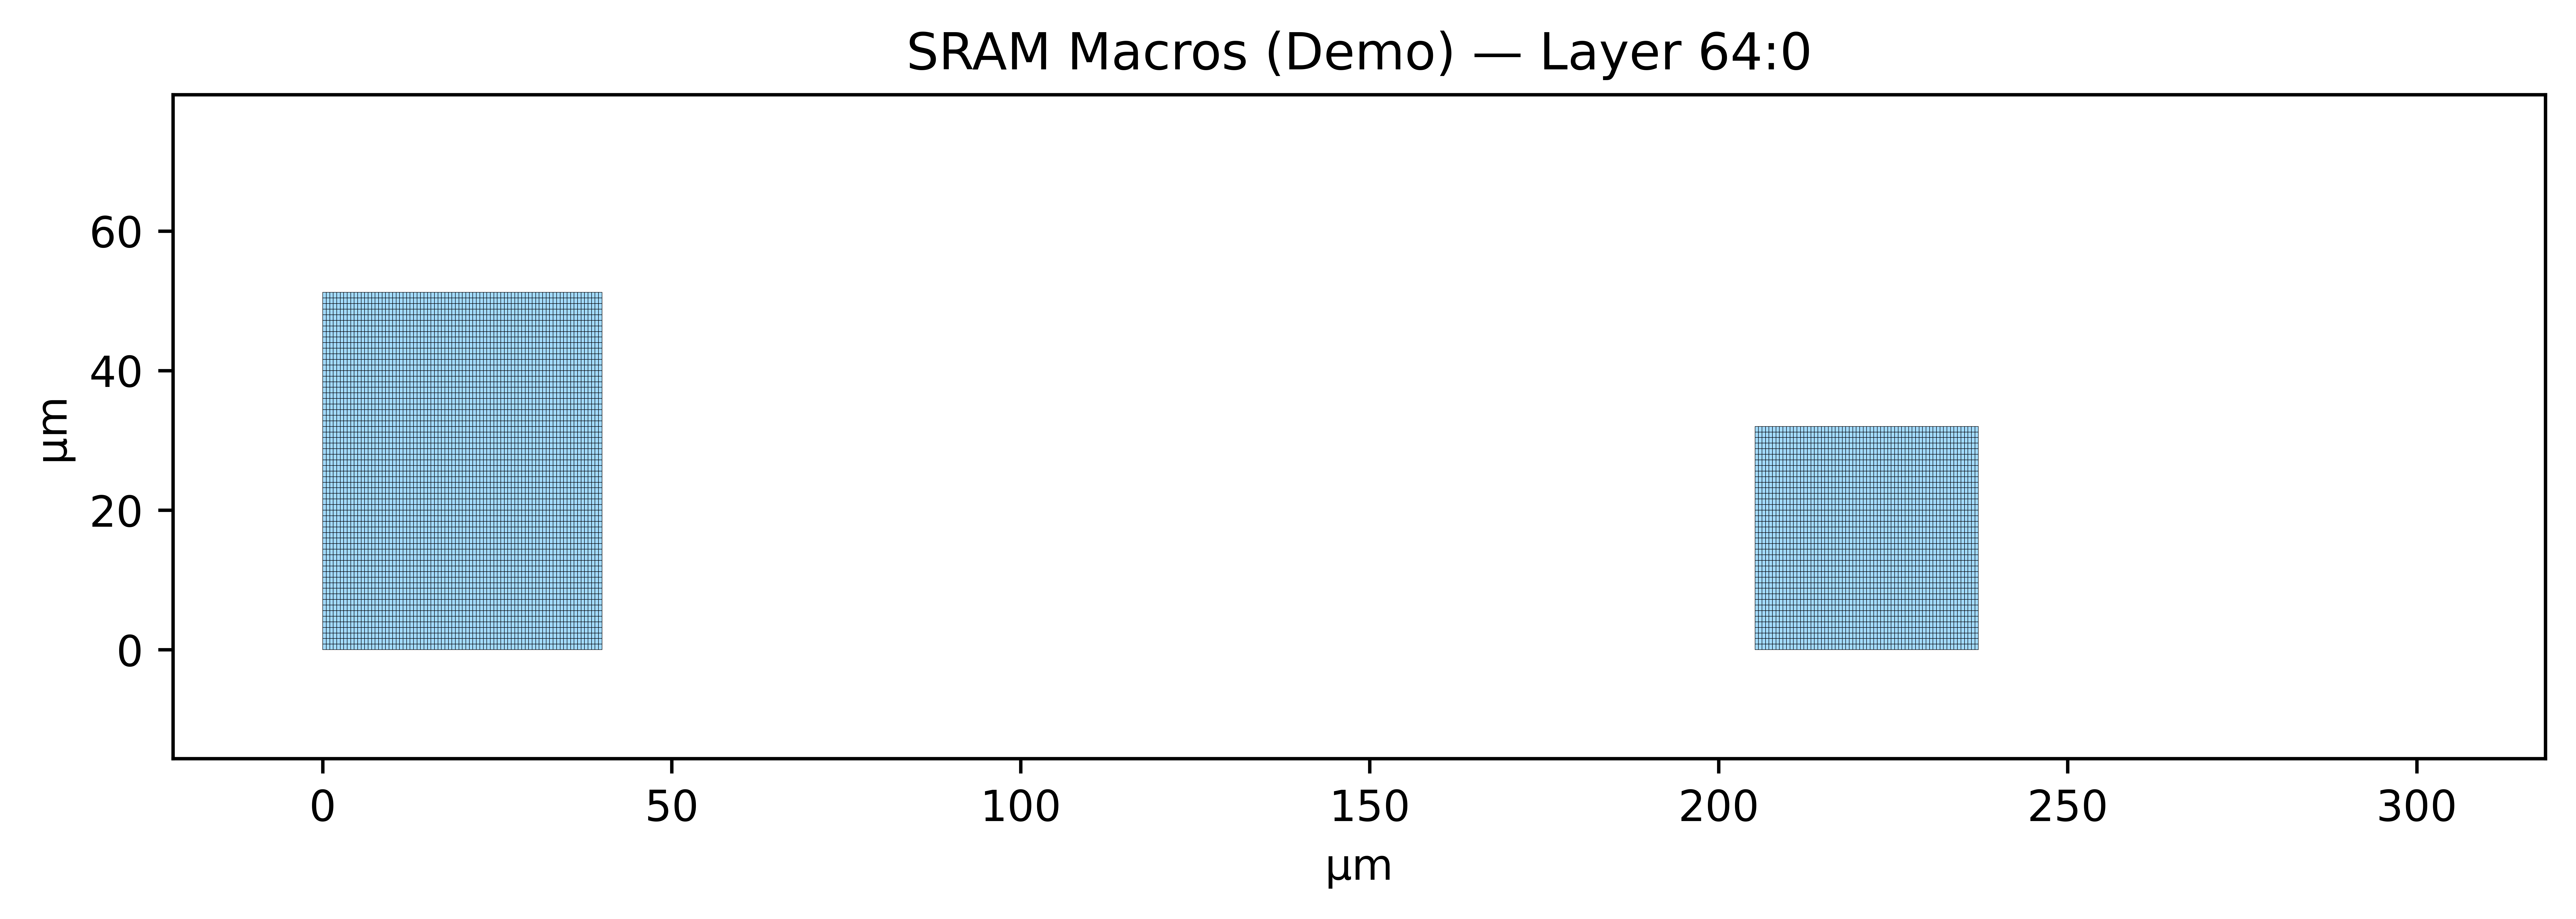

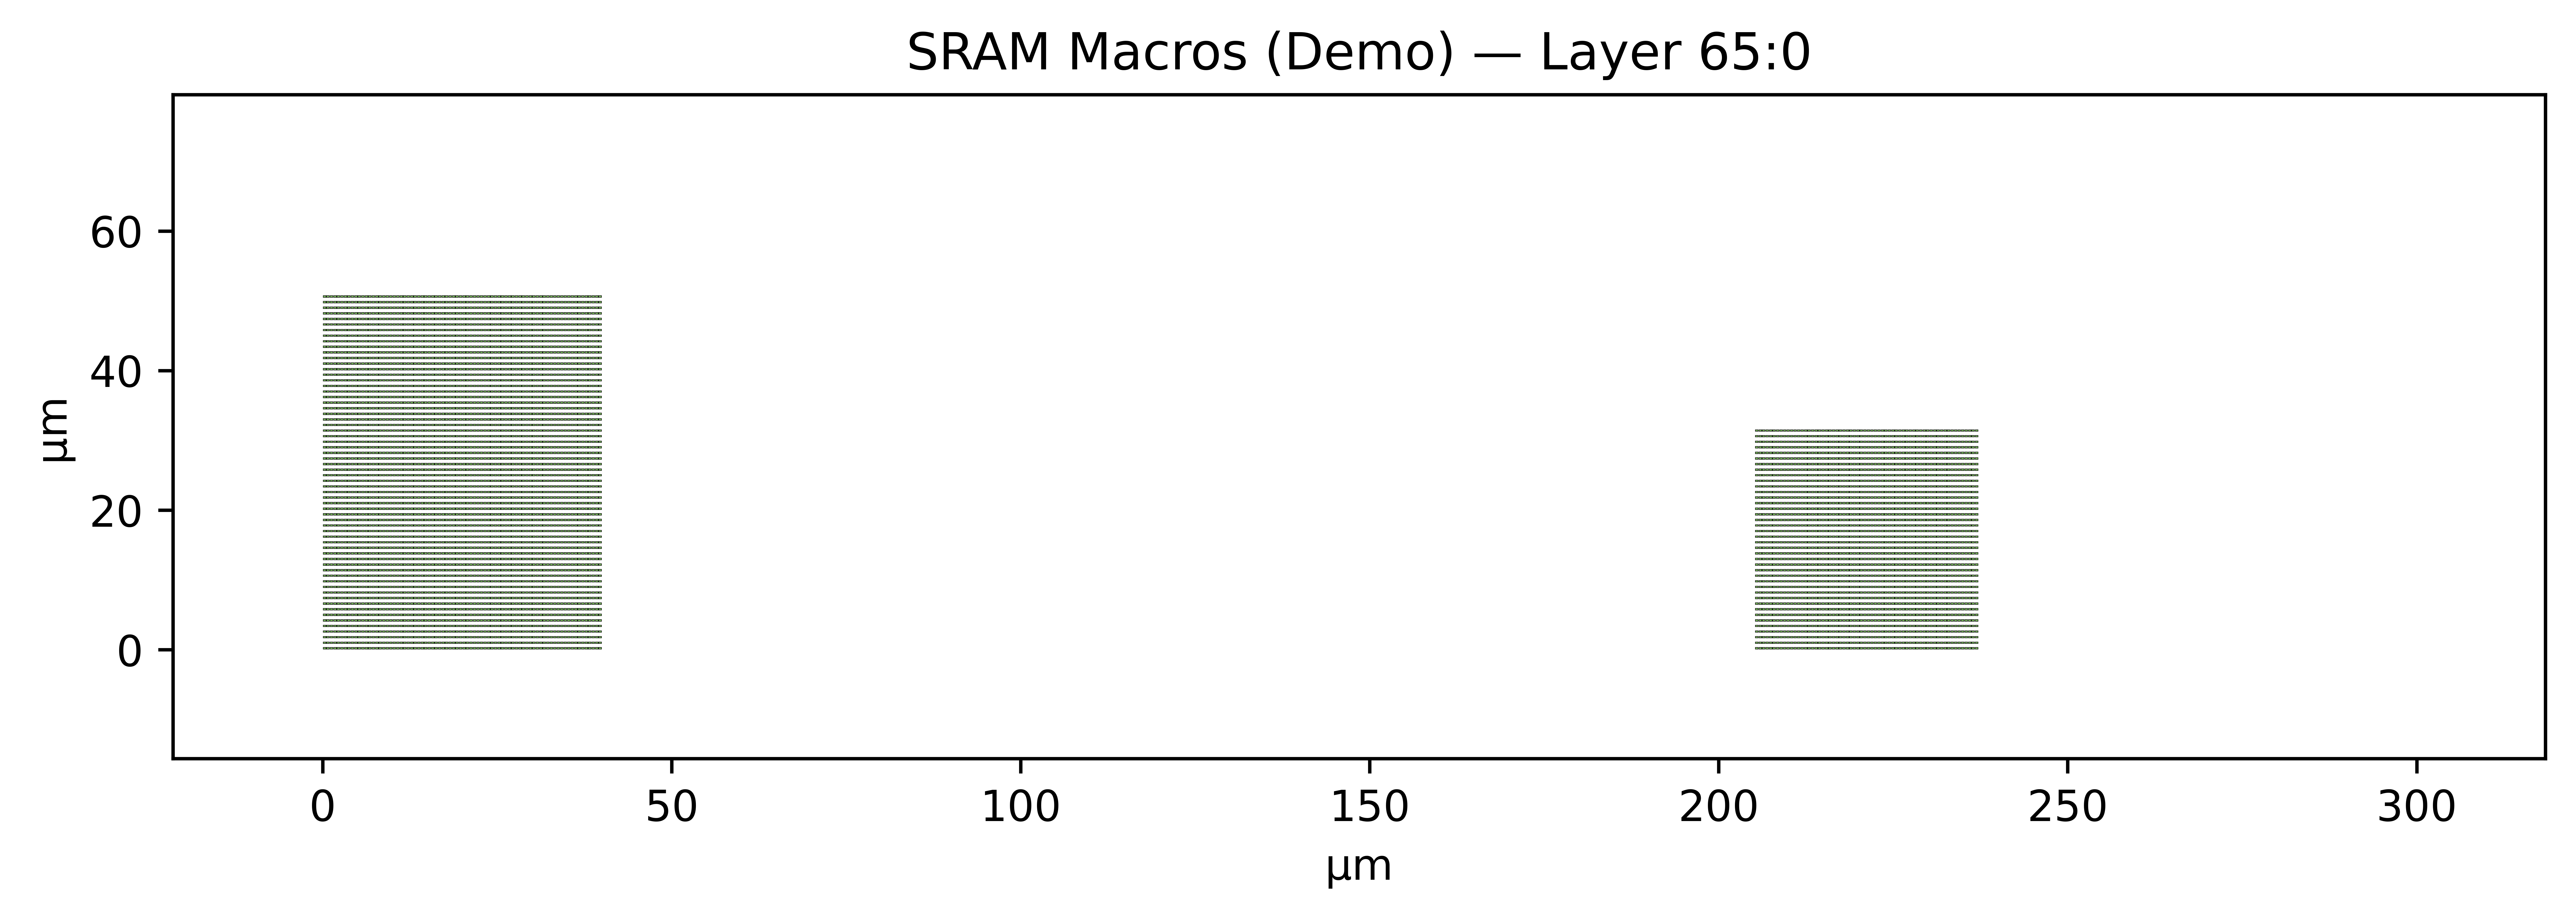

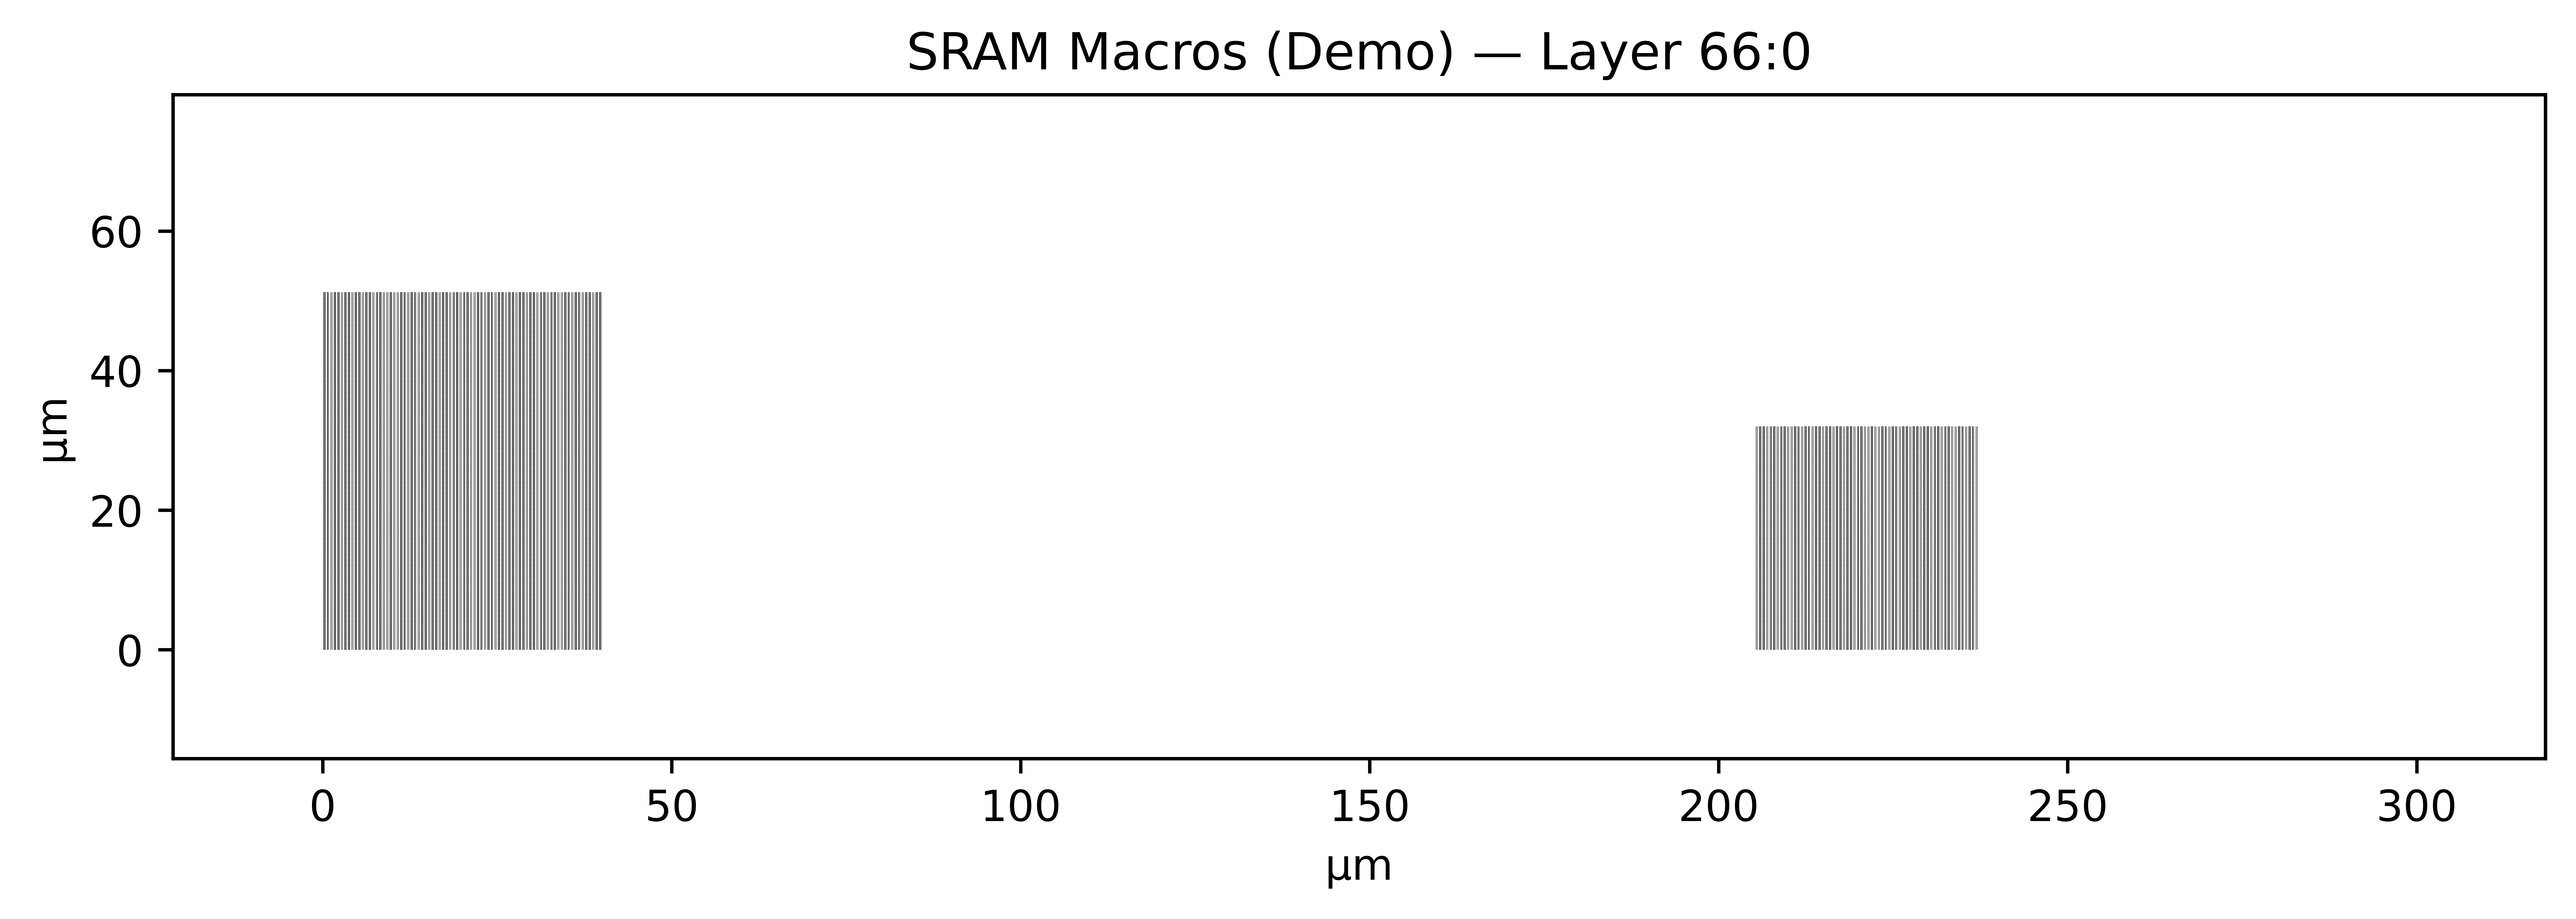

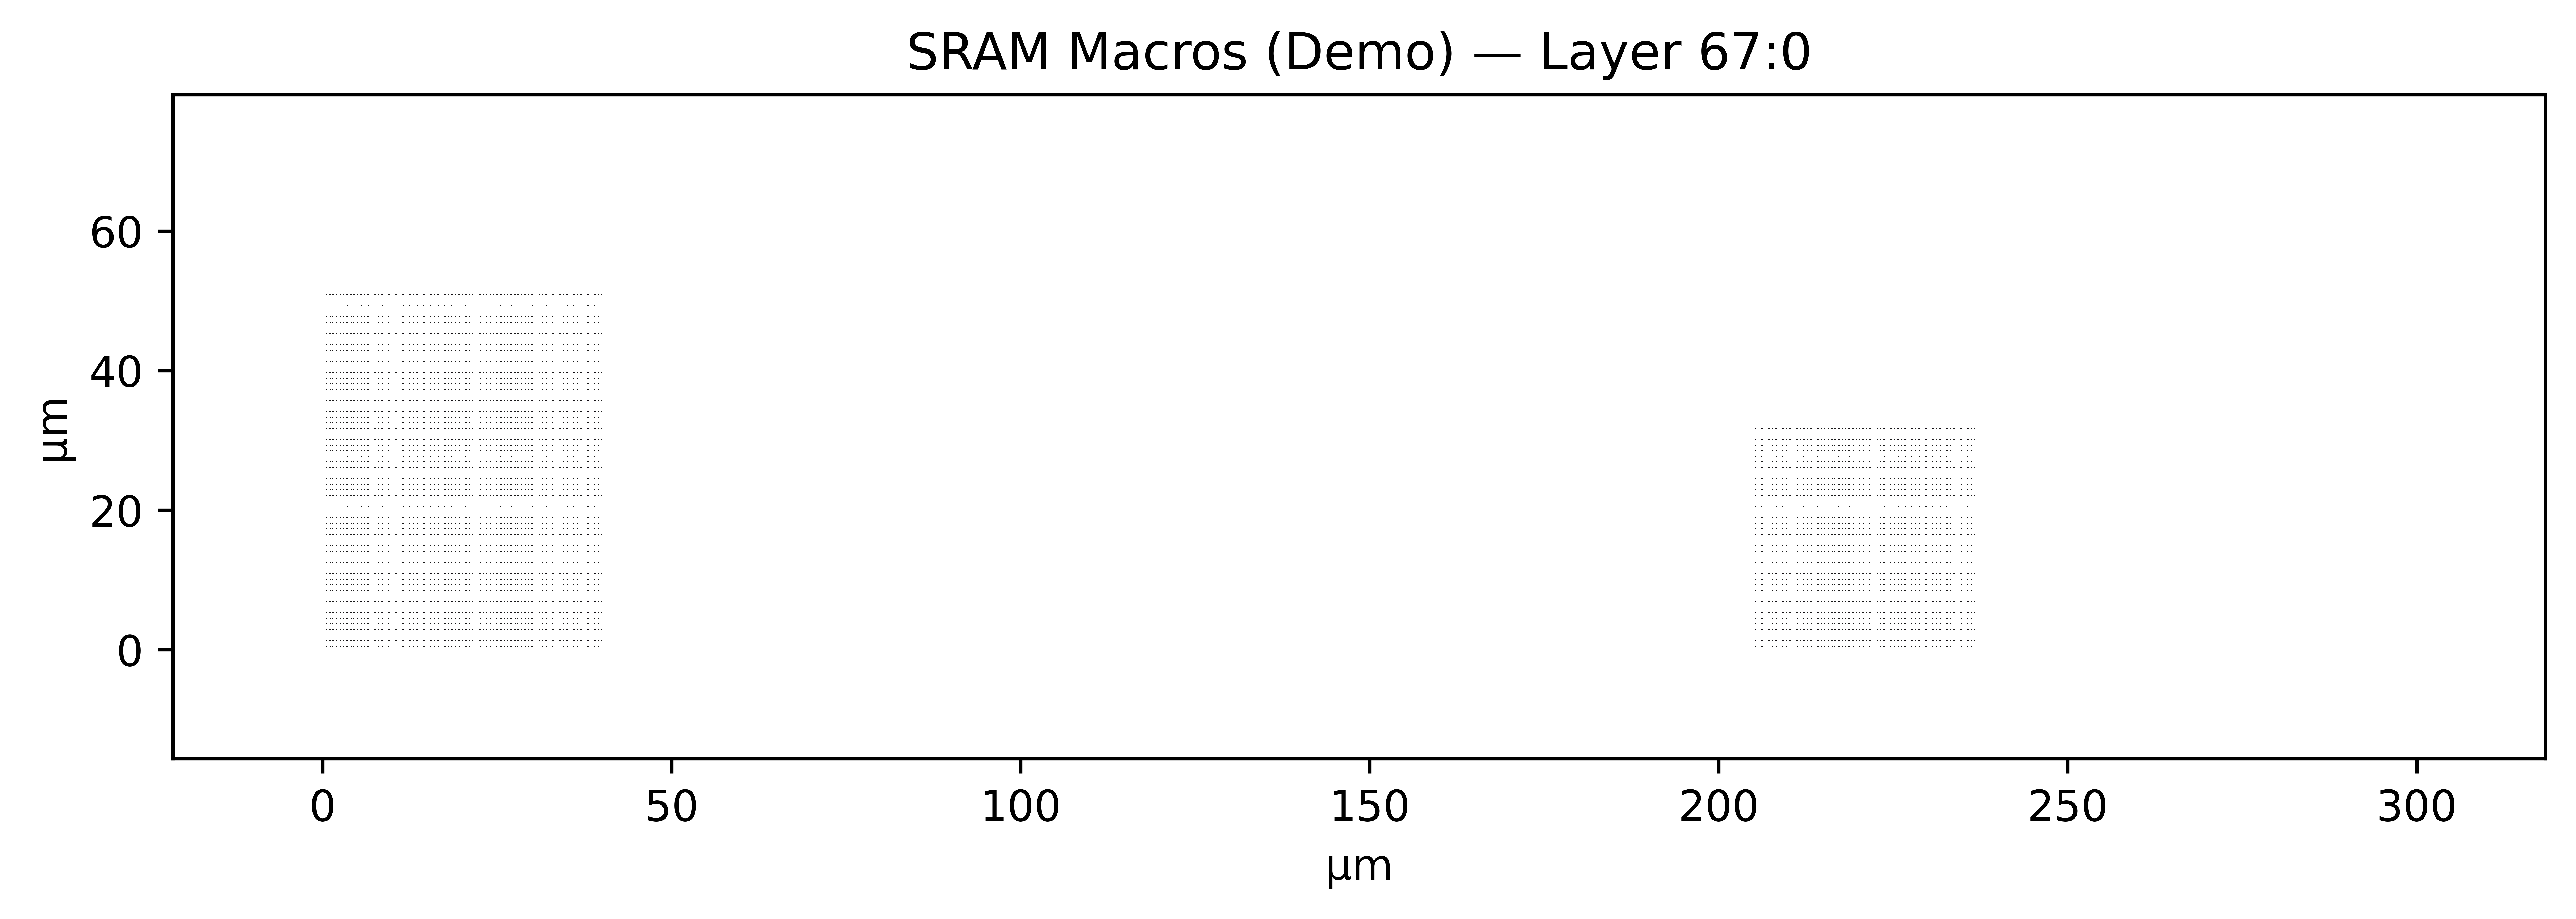

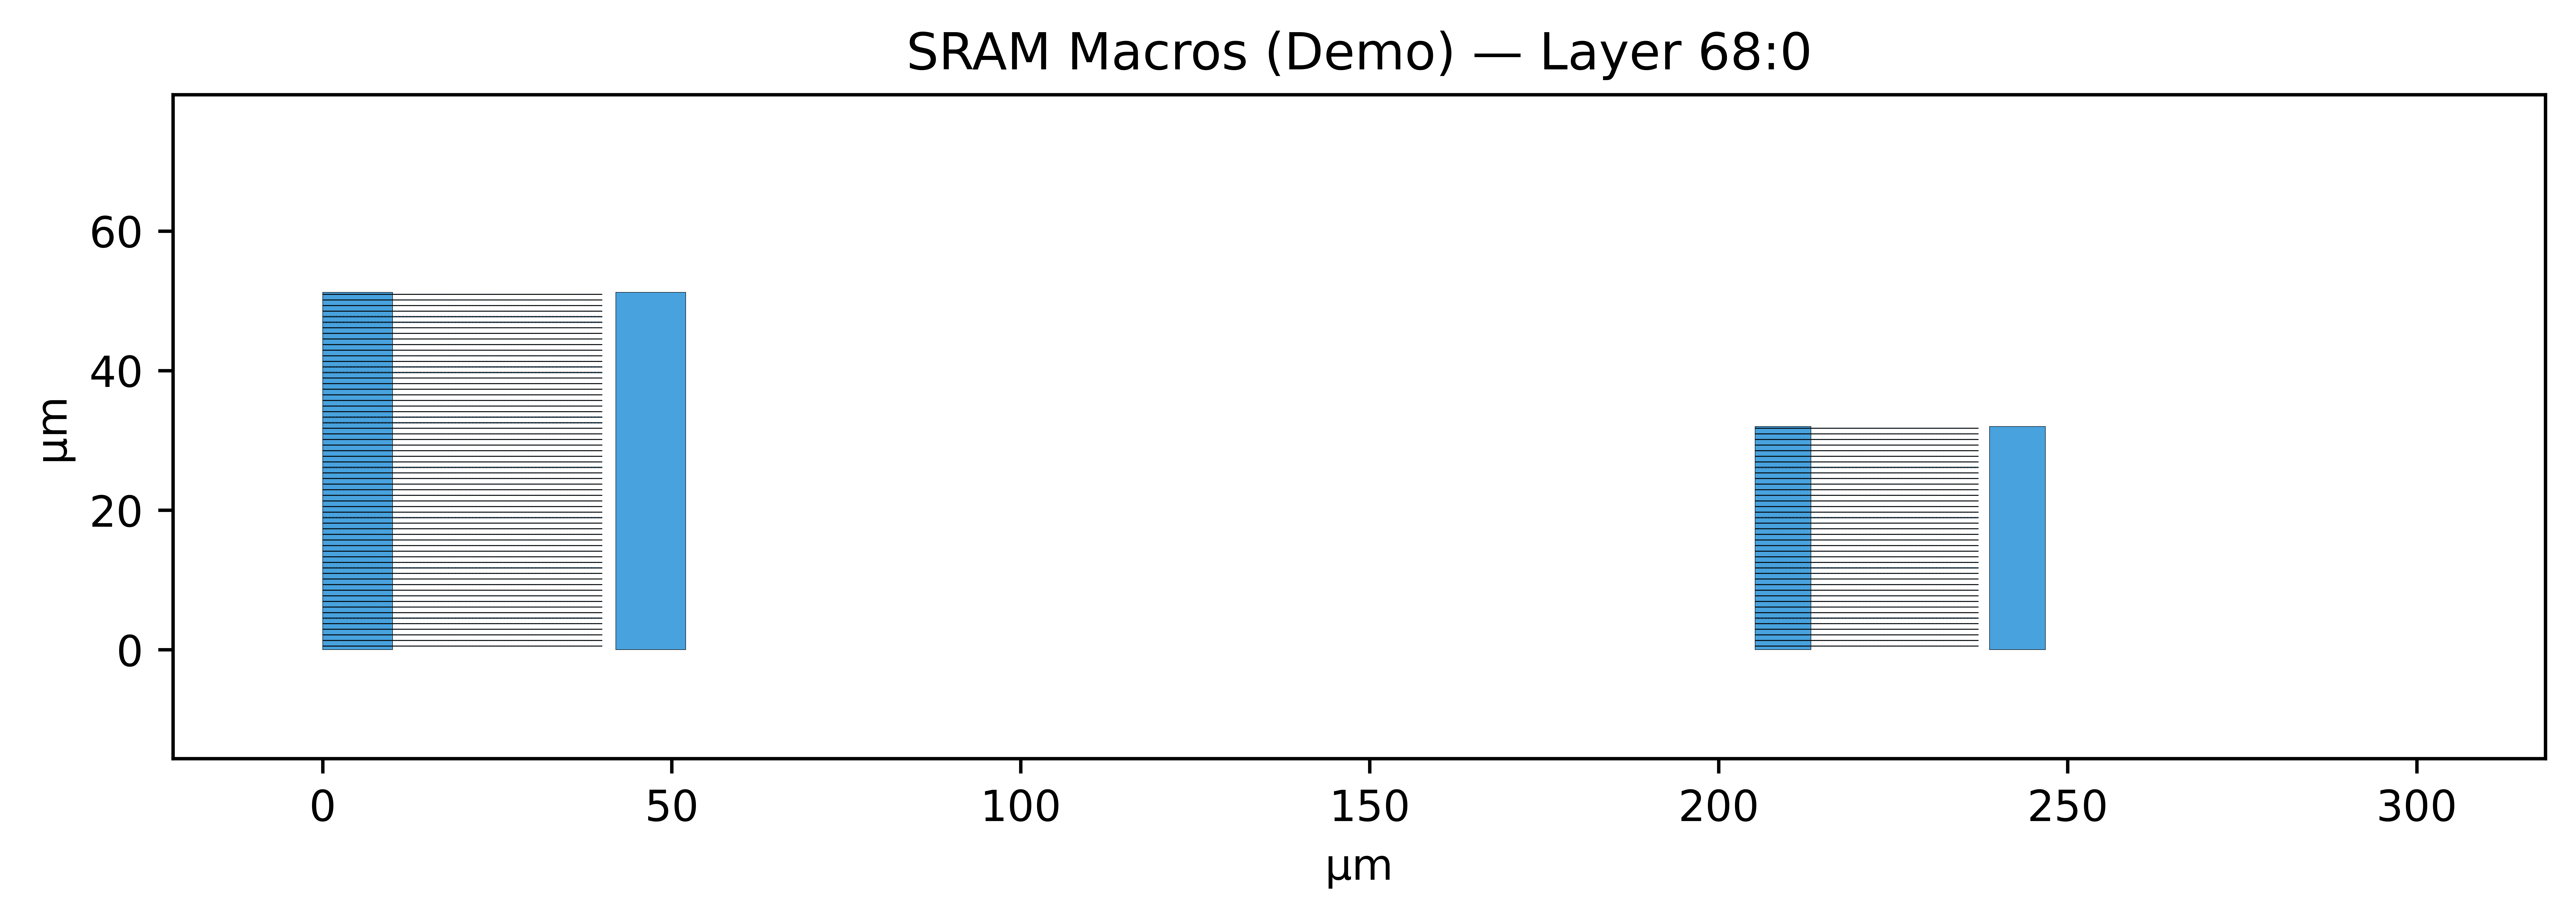

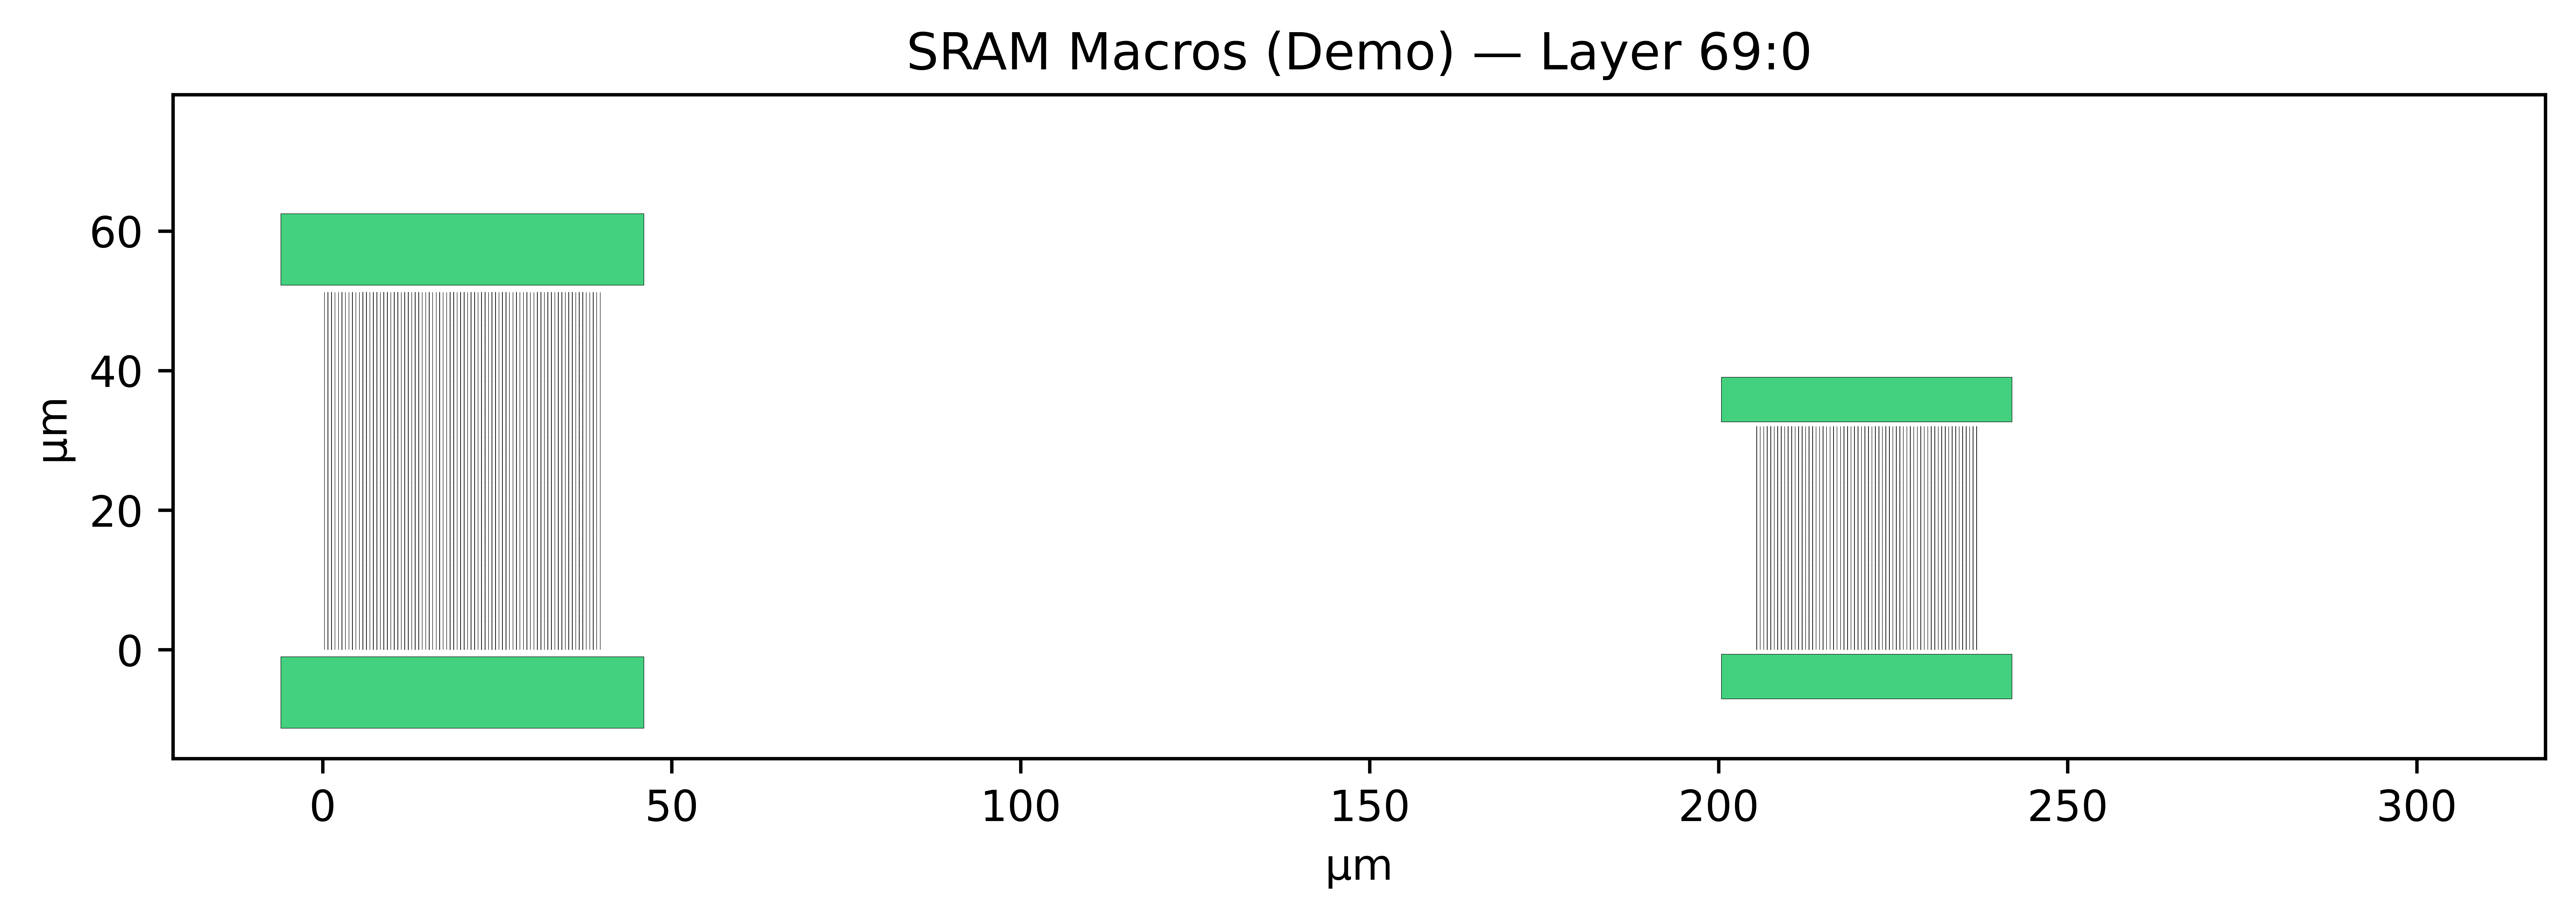

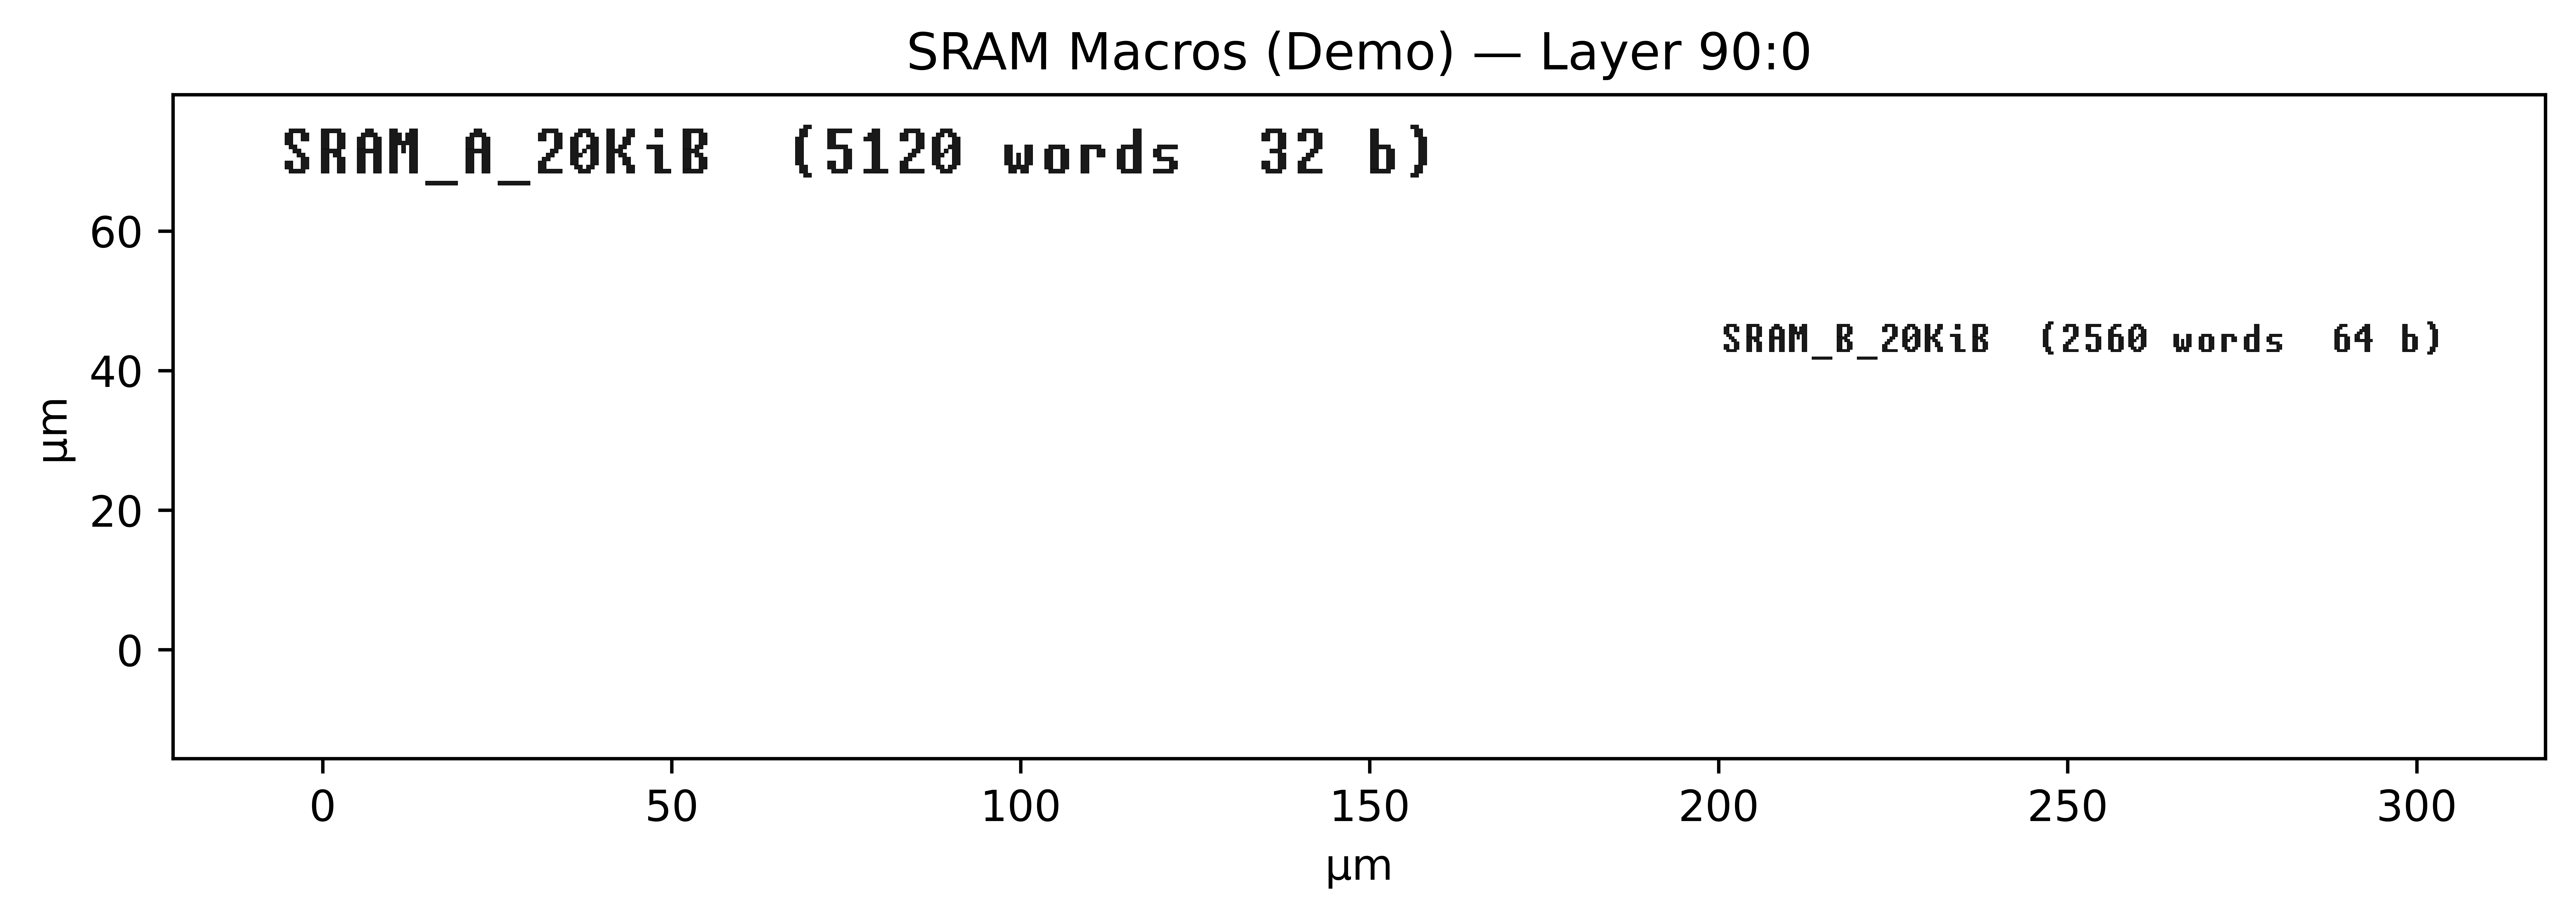

In [5]:
# @title View previews inline
from IPython.display import Image, display
prev_dir = Path("/content/out/previews")
imgs = sorted(prev_dir.glob("*.png"))
if not imgs:
    raise FileNotFoundError(f"No previews found in {prev_dir}.")
for img in imgs:
    display(Image(filename=str(img)))

In [6]:
# @title Download: OASIS and bundle
from google.colab import files
from pathlib import Path
import zipfile

root = Path("/content/out")
oas = root / "sram_macros.oas"
assert oas.exists(), "OASIS file not found."

# Single-file download
files.download(str(oas))

# Bundle (OASIS + previews + SVG + LYP)
bundle = Path("/content/sram_macros_bundle.zip")
if bundle.exists():
    bundle.unlink()
with zipfile.ZipFile(bundle, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    zf.write(oas, arcname="sram_macros.oas")
    for p in (root / "previews").glob("*.png"):
        zf.write(p, arcname=f"previews/{p.name}")
    for p in (root / "svg").glob("*.svg"):
        zf.write(p, arcname=f"svg/{p.name}")
    zf.write(root / "sram_layers.lyp", arcname="sram_layers.lyp")
files.download(str(bundle))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title (Optional) Run via CLI with tolerant argparse
# This works because the script uses parse_known_args.
%run /content/sram_oasis_generator.py --preview_mode full --binary_bytes --out_root /content/out
